In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 

import pandas as pd
import torch.nn as nn
import torch.optim as optim

import xarray as xr

import torch.nn as nn
import torch.optim as optim
import torch

In [9]:
df1 = pd.read_csv('data/table(2).csv',delimiter=';', skipfooter=1, engine='python', na_values='-')
df2 = pd.read_csv('data/table(3).csv',delimiter=';', skipfooter=1, engine='python', na_values='-')
df1.index= pd.to_datetime(df1['Tid(norsk normaltid)'], dayfirst=True).rename('date')
df2.index= pd.to_datetime(df2['Tid(norsk normaltid)'], dayfirst=True).rename('date')
df1 = df1.iloc[:,3:].sort_index()
df2 = df2.iloc[:,3:].sort_index()
df1.columns = ['Tmax','Tmean','Tmin','Pr','Snowdepth']
df1['wind']=df2['Middel av middelvind fra hovedobs. (døgn)']
# df3 = pd.read_csv('/home/rogui7909/code/ML_course/GFI-ML-evening-course/data/table(4).csv',delimiter=';', skipfooter=1, engine='python')
df = df1.astype(float).to_xarray().interpolate_na('date').to_dataframe().dropna().resample('W').mean()
df['snow_change'] = df.Snowdepth.diff().fillna(0)
df['snow_week_before'] = df.Snowdepth.shift(1).fillna(0)
df['snow_week_after'] = df.Snowdepth.shift(-4).fillna(0)

df = df.dropna()


In [10]:
df.corr()

,Tmax,Tmean,Tmin,Pr,Snowdepth,wind,snow_change,snow_week_before,snow_week_after
Tmax,1.000000,0.985681,0.977889,-0.078574,-0.543204,-0.348000,-0.308725,-0.459885,-0.646256
Tmean,0.985681,1.000000,0.985503,-0.071864,-0.577286,-0.305019,-0.293043,-0.498443,-0.656028
Tmin,0.977889,0.985503,1.000000,-0.045745,-0.589421,-0.291690,-0.277581,-0.515009,-0.660030
Pr,-0.078574,-0.071864,-0.045745,1.000000,0.120464,0.099883,0.239003,0.060850,0.177403
Snowdepth,-0.543204,-0.577286,-0.589421,0.120464,1.000000,0.279145,0.125843,0.965093,0.788800
wind,-0.348000,-0.305019,-0.291690,0.099883,0.279145,1.000000,0.057313,0.259430,0.397594
snow_change,-0.308725,-0.293043,-0.277581,0.239003,0.125843,0.057313,1.000000,-0.129244,0.269103
snow_week_before,-0.459885,-0.498443,-0.515009,0.060850,0.965093,0.259430,-0.129244,1.000000,0.717567
snow_week_after,-0.646256,-0.656028,-0.660030,0.177403,0.788800,0.397594,0.269103,0.717567,1.000000


In [11]:
X = df[['Tmax','Tmean','Tmin','Pr']].values
# X = df[['Snowdepth','Snowdepth','Snowdepth','Snowdepth','Snowdepth']].values

y = df[['Snowdepth']].values

In [20]:
model = nn.Sequential(
    nn.Linear(4, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)
model

Sequential(
  (0): Linear(in_features=4, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=12, bias=True)
  (3): ReLU()
  (4): Linear(in_features=12, out_features=6, bias=True)
  (5): ReLU()
  (6): Linear(in_features=6, out_features=1, bias=True)
)

In [21]:
import torch.nn as nn
import torch.optim as optim

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [22]:
import copy
import numpy as np
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# training parameters
n_epochs = 200   # number of epochs to run
batch_size = 512  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

# training loop
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
# restore model and return best accuracy
model.load_state_dict(best_weights)

100%|██████████| 200/200 [00:07<00:00, 26.03it/s]


<All keys matched successfully>

MSE: 5645.38
RMSE: 75.14


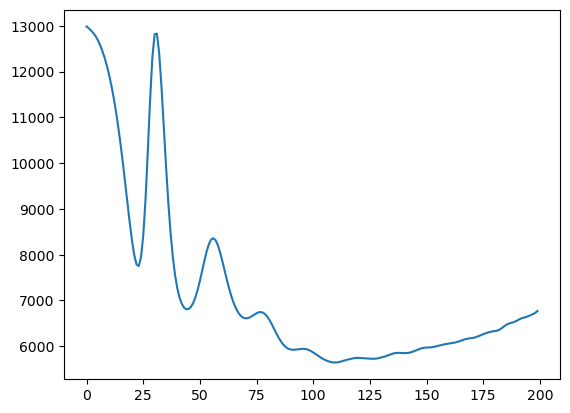

In [23]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

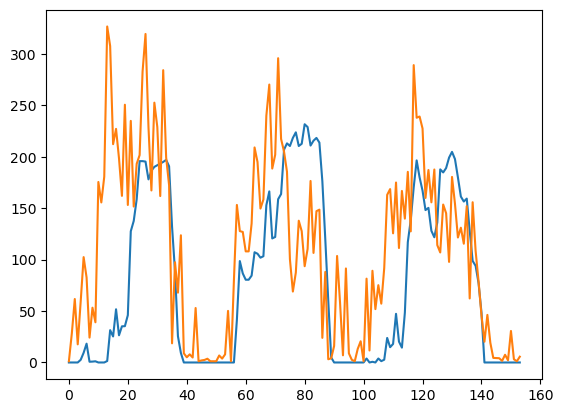

In [26]:
plt.plot(y_test)
plt.plot(y_pred.detach())